<a href="https://colab.research.google.com/github/BastienBoucherat/geo6149/blob/main/geo6149_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etude de la capacité théorique d'autonomie alimentaire du territoire**
---

GEO-6149: Géomatique

*   Bastien Boucherat (20155314)
*   Juliette Goulet ()


# **Configuration de l'environnement de travail**
*    Création des dossiers sur Google Colab
*    Installation de paquets python additionnels
*    Importation des paquets python nécessaires
*    Récupération des données distantes

## Quelques définitions utiles (1)

Définitions relatives à l'analyse géomatique

In [5]:
# Coordinate system for Latitude-Longitude
geo_crs = 'EPSG:4326'

# Projection used for plots (web Mercator)
plot_crs = 'EPSG:3857'

# Coordinate system used throughout the study
study_crs = 'EPSG:32188'

Définitions relatives à la gestion des fichiers sur Google Colab

In [6]:
# This folder is the projet root folder in Google Colab
project_folder = "/content"

# This folder will contain any temporary files
tmp_folder = project_folder + "/tmp"

# This folder will contain persistent data
data_folder = project_folder + "/data"

# This folder will contain generated outputs
output_folder = project_folder + "/output"

## Arborescence des dossiers
Création de quelques dossiers de travail sur Google Colab.

In [7]:
# Packages necessary to handle files in Google Colab.
# https://docs.python.org/3/library/os.path.html
import os
import os.path

# Create folder is not already there (tmp)
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

# Create folder is not already there (data)
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

# Create folder is not already there (output)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Installation des paquets

Installation de **GeoPandas** pour le traitement des données géospatiales

In [8]:
# Install Geopandas
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install geopandas

Installation de **RasterIO** pour le traitement des données matricielles

In [9]:
# Install rasterIO
%%capture
!pip install rasterio

Installation de **Contextily** pour ajouter des fonds de cartes

In [10]:
# Install contextily for map visualisation
%%capture
!pip install contextily

## Importation des paquets

In [11]:
# Data processing
import numpy as np
import pandas as pd

In [12]:
# Geodata processing

# GeoPandas
import geopandas as gpd

# RasterIO
import rasterio
import rasterio.plot
import rasterio.mask

In [13]:
# Data format
import json

In [14]:
# Data visualisation
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

## Chargement des données distantes

*   Chargement de la configuration des sources de données
*   Téléchargement des données distantes
*   Extraction des archives compressées (au besoin)
*   Sauvegarde des fichiers nécessaires
*   Suppression des fichiers inutiles

### Configuration des sources
La configuration est contenue dans un fichier de description des sources de donnnées distantes

In [15]:
# Load remote data sources information
data_sources_df = pd.read_csv(project_folder + '/data_sources.csv')
data_sources_df['Year'] = pd.to_datetime(data_sources_df['Year'], format="%Y").dt.year

# Download only from selected data sources
data_sources_df = data_sources_df[data_sources_df['Use?']==True]

### Copie des données distantes

In [16]:
%%capture

# Remote files will be downloaded and extracted in this folder
# Then, downloaded files will be used to generate pre-processed data files eventually stored locally in another folder
%cd {tmp_folder}

# For selected each source
for idx, data_source in data_sources_df.iterrows():

    # This will point to the useful file to save
    useful_file = ''

    # Get some information from the link
    data_file = data_source['Link'].split('/')[-1]
    data_file_name = data_file.split('.')[0]
    data_file_type = data_file.split('.')[-1] # file extension
    
    # Download source from internet
    if not os.path.exists(data_file):
        source_url = data_source['Link']
        # wget [URL] -P [Directory]
        !wget $source_url
    
    # Extract (if applicable)
    if data_file_type.lower() in ['zip']:

        # Where?
        extract_folder = data_file_name
 
        # Extract
        !unzip -u $data_file -d $extract_folder

        # Save path to file
        useful_file= useful_file + f"{extract_folder}/{data_source['File Name']}"
    else:
        # Save path to file
        useful_file = data_file_name

    # Save the useful files to a persistent folder

    # Shapefile
    if data_source['Format'] == 'shapefile':

        # List of desired file types
        file_types = ['shp','shx','dbf','prj']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"

        # Copy all necessary files
        for file_type in file_types:
            src_file = f'{useful_file}.{file_type}'
            dest_file = f'{target_file}.{file_type}'
            !cp $src_file $dest_file

        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.shp'
    
    # Geotiff
    elif data_source['Format'] == 'geotiff':
        
        # List of desired file types
        file_types = ['tif','tiff']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"
        print(f"Target file: {target_file}")

        # Try for every potentiel type of file
        for file_type in file_types:

            src_file = f'{useful_file}.{file_type}'
            print(f"Target file: {src_file}")
            # Copy every file that is found
            if os.path.exists(src_file):
                dest_file = f'{target_file}.{file_type}'
                dest_file_type = file_type
                !cp $src_file $dest_file
        
        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.{dest_file_type}'

### Nettoyage des fichiers temporaires


In [17]:
# Remove temporary files
if True:
    # Remove files from extraction folders
    command = f'{tmp_folder}/*/*'
    !rm $command
    # Remove extraction folders themselves
    command = f'{tmp_folder}/*'
    !rmdir $command

# Remove downloaded source files
if False:
    # Remove zip files
    command = f'{tmp_folder}/*.zip'
    !rm $command

# Remove useless columns from data source description
data_sources_df = data_sources_df.drop(['Link', 'Use?', 'File Name'], axis='columns')

rmdir: failed to remove '/content/tmp/CanadaLandcover2015.zip': Not a directory
rmdir: failed to remove '/content/tmp/cb_2018_us_state_500k.zip': Not a directory
rmdir: failed to remove '/content/tmp/lpr_000b16a_e.zip': Not a directory
rmdir: failed to remove '/content/tmp/ppp_2020_1km_Aggregated.tif': Not a directory


In [18]:
# Export updated data sources information
data_sources_df.to_csv(output_folder + '/data_sources.csv')

# **Préparation des données génériques**

## Données administratives

**Chargement des frontières administratives** (Etats-Unis)

In [19]:
# Select US boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'USA')]['Location'].item()

# Load vector data
us_boundaries_gdf = gpd.read_file(file_name)

# Check coordinate system
if us_boundaries_gdf.crs == 'None':
    print("Error: CRS information is missing")
else:
    us_boundaries_gdf = us_boundaries_gdf.to_crs(study_crs)

# Cherry-pick and rename information
us_boundaries_gdf['NATION_ID']="USA"
us_boundaries_gdf = us_boundaries_gdf.rename(columns={'STUSPS':'SUB_NATION_ID','NAME':'SUB_NATION_NAME'})
us_boundaries_gdf = us_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

In [20]:
# States that are outside North American continent: Samoa, Virgin Islands, Guam, Mariana Islands, Hawai, Puerto Rico
outside_states = ['AS','VI','GU', 'MP', 'HI', 'PR']

# Remove states outisde of North America
us_boundaries_gdf = us_boundaries_gdf[~us_boundaries_gdf['SUB_NATION_ID'].isin(outside_states)]

**Chargement des frontières administratives** (Canada)

In [21]:
# Select Canada boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'Canada')]['Location'].item()

# Load vector data
can_boundaries_gdf = gpd.read_file(file_name)

# Check coordinate system
if can_boundaries_gdf.crs == 'None':
    print("Error: CRS is missing")
else:
    can_boundaries_gdf = can_boundaries_gdf.to_crs(study_crs)

# Cherry-pick and rename information
can_boundaries_gdf['NATION_ID']="CAN"
can_boundaries_gdf = can_boundaries_gdf.rename(columns={'PREABBR':'SUB_NATION_ID','PRENAME':'SUB_NATION_NAME'})
can_boundaries_gdf = can_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

**Sauvegarde des donnnées administratives** (Canada et Etat-Unis)

In [22]:
# Merge data for Canada+USA
boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)

# Define index
boundaries_gdf.set_index(['NATION_ID', 'SUB_NATION_ID'], inplace=True)

<ipython-input-22-733300387243>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)


In [23]:
# Geometries from Statistiques Canada are really precise, hence very heavy.
# Let's make data lighter: this is done on all boundaries (US and Canada) so that precision is consistent across data
minimum_distance_km = 10
boundaries_gdf['geometry'] = boundaries_gdf['geometry'].simplify(minimum_distance_km*1000, preserve_topology = 'True')

In [24]:
# Save as a file
pd.DataFrame(boundaries_gdf).to_csv(output_folder + '/Boundaries.csv')

# **Analyse préliminaire pour le Québec**
Il s'agit ici d'effectuer quelques calculs simples pour le Québec afin de vérifier que notre manipulation des structures de données est correcte.

In [25]:
# Extract the geodataframe for Quebec
qc_gdf = boundaries_gdf.loc[[('CAN','Que.')]]

**Population du Québec**

In [26]:
# Load the population raster
pop_raster = rasterio.open(f'{data_folder}/Population_World.tif')

# Check coordinate system
if pop_raster.crs == 'None':
    print("Warning: loaded raster is missing CRS")

# Create mask for Quebec
qc_mask = [json.loads(qc_gdf.to_crs(pop_raster.crs).to_json())['features'][0]['geometry']]

# Extract the population data for Quebec from clipped raster
qc_pop_data = rasterio.mask.mask(pop_raster, qc_mask, crop=True)[0]

# Compute the total population of Quebec
print(f"There are around {round(sum(qc_pop_data[qc_pop_data>=0])/1e6,1)} million inhabitants in Quebec")

There are around 7.9 million inhabitants in Quebec


# **Définition de la zone d'étude**

## Centres urbains

Définition des centres urbains à considérer dans notre analyse.



In [27]:
from shapely.geometry import Point

# Create a list of the urban centers to include in the study
urban_centers_names = ["Montreal"]

# TODO: use Google maps API to get coordinates from names
# For now, manually provide coordinates
urban_centers_coordinates = [[-73.623983, 45.512047]]

# Create a geometry from the coordinates
# TODO: handle more than one urban center
urban_centers_geometry = [Point(urban_centers_coordinates[0])]

# Save information as geodataframe associating urban centers with their respective geometry
urban_centers = gpd.GeoDataFrame({'Name': urban_centers_names, 'geometry': urban_centers_geometry}, geometry='geometry')

# Provide the coordinate system
urban_centers.crs = geo_crs

# Project to the desired CRS
urban_centers = urban_centers.to_crs(study_crs)

## Zone d'étude

In [28]:
# Center the study area on a city
study_area_center = urban_centers[urban_centers['Name']=='Montreal']

# Create a study area around this center
radius_km = 300
study_area = study_area_center.buffer(radius_km*1e3, resolution=16)

# Create geodataframe from geometry
study_gdf = gpd.GeoDataFrame(geometry=study_area)

# Provide the CRS with which is was created
study_gdf.crs = study_crs

On exporte un fichier geojson de la zone d'étude pour sauvegarde:

In [29]:
# Save the geometry as geoJSON
# geoJSON format requires EPSG:4326
file_name = "Perimeter_study.geojson"
study_gdf.to_crs(geo_crs).to_file(f'{output_folder}/{file_name}', driver='GeoJSON')

On affiche la zone d'étude pour vérifier que tout est correct:

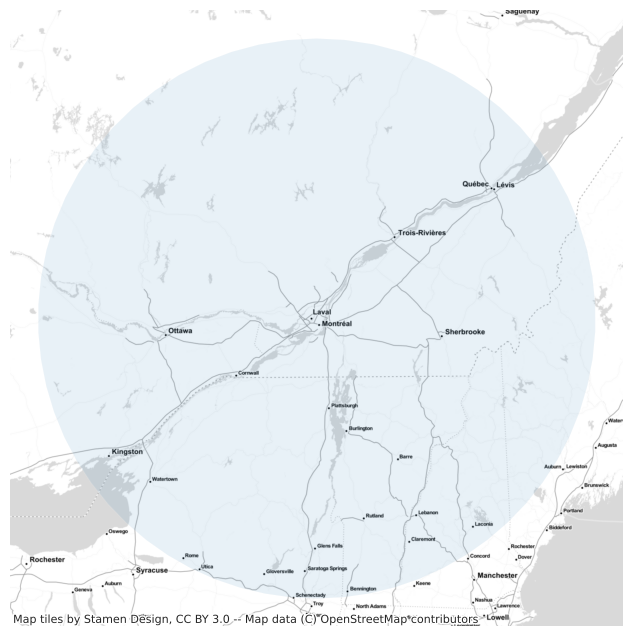

In [66]:
# Create a layer containing the study area
layer_1 = study_gdf.to_crs(plot_crs).plot(alpha=0.1, figsize=(8, 8))

# Beautify https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
cx.add_basemap(layer_1, source=cx.providers.Stamen.TonerLite, zoom=8)
layer_1.set_axis_off()

# **Préparation des données pour la zone d'étude**
*   Application du masque aux données d'entrée de population
*   Application du masque aux données d'entrée agricoles

## Population (données matricielles)

In [31]:
# Population raster file
file_name = 'Population_World.tif'

# Load population raster
pop_raster = rasterio.open(f'{data_folder}/{file_name}')

# Check coordinate system
if pop_raster.crs == 'None':
    print("Warning: loaded raster is missing CRS")

In [32]:
# Create a mask corresponding to the study area in the raster's coordinate system
study_mask = [json.loads(study_gdf.to_crs(pop_raster.crs).to_json())['features'][0]['geometry']]

# Clip the raster with the mask
# The clipped output loses the geospatial information
# So we also save the geospatial information alongside
study_pop_np, study_pop_transform = rasterio.mask.mask(pop_raster, study_mask, crop=True)

# Reintegrate geopspatial information
study_pop_metadata = pop_raster.meta # reuse the metadata from the original file
study_pop_metadata.update({"driver": "GTiff",
                           "height": study_pop_np.shape[1],
                           "width": study_pop_np.shape[2],
                           "transform": study_pop_transform})

# Save the clipped population raster (i.e. limited to the study area)
with rasterio.open(output_folder + "/Population_study.tif", "w", **study_pop_metadata) as dest:
    dest.write(study_pop_np)

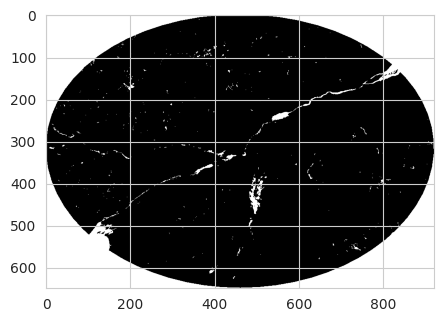

In [33]:
# Quick show of the clipped data according to the mask
plt.figure(figsize = (5,5))
plt.imshow(study_pop_np[0], cmap='Greys')

## Terres agricoles (données matricielles)

In [34]:
# Land raster file
file_name = 'Land_Canada.tif'

# Load land raster
land_raster = rasterio.open(f'{data_folder}/{file_name}')

# Check coordinate system
if land_raster.crs == 'None':
    print("Warning: loaded raster is missing CRS")

In [35]:
# Create a mask corresponding to the study area in the raster's coordinate system
study_mask = [json.loads(study_gdf.to_crs(land_raster.crs).to_json())['features'][0]['geometry']]

# Clip the raster with the mask
# The clipped output loses the geospatial information
# So we also save the geospatial information alongside
study_land_np, study_land_transform = rasterio.mask.mask(land_raster, study_mask, crop=True)

# Reintegrate geopspatial information
study_land_metadata = land_raster.meta # reuse the metadata from the original file
study_land_metadata.update({"driver": "GTiff",
                           "height": study_land_np.shape[1],
                           "width": study_land_np.shape[2],
                           "transform": study_land_transform})

# Save the clipped land cover raster (i.e. limited to the study area)
with rasterio.open(output_folder + "/Land_study.tif", "w", **study_land_metadata) as dest:
    dest.write(study_land_np)

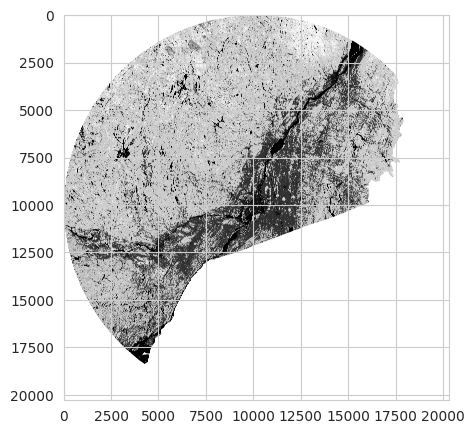

In [36]:
# Quick show of the clipped data according to the mask
plt.figure(figsize = (5,5))
plt.imshow(study_land_np[0], cmap='Greys')

## Données statistiques

**Données nutritionnelles**

In [37]:
# Human nutrition requirements (energy per day per capita)
daily_human_energy_kJ_min = 7536 # 1800 kilocalories = 7536 kJ
daily_human_energy_kJ_canada = 14930 # 3566 kilocalories = 14930 kJ

# Annual human requirements (energy per year per capita)
# [minium canada]
annual_human_energy_kJ_req = {
    'minimum': daily_human_energy_kJ_min * 365,
    'canada': daily_human_energy_kJ_canada * 365
    }

**Données de productivité agricole**

In [38]:
# Food energy content (energy per mass)
# https://www.fao.org/3/y5022e/y5022e04.htm
food_energy = 17000 # kJ/kg (cereal)

# Food productivity (mass per surface per year)
annual_food_productivity = 3000 # kg/ha/year https://ourworldindata.org/crop-yields (FAO)

# Energy productivity (energy per surface per year) 
annual_energy_productivity = food_energy * annual_food_productivity # kJ/ha/year

# **Analyse préliminaire pour la zone d'étude**

**Population**

Chargement des données de population



In [39]:
# Population raster file for our study
file_name = 'Population_study.tif'

# Load population raster
study_pop_raster = rasterio.open(f'{output_folder}/{file_name}')

Calcul de la population

In [40]:
# Extract the population data from raster
pop_data = study_pop_raster.read()[0]

# Compute the total population present in the study area
study_pop = sum(pop_data[pop_data>=0])

# Print results
print(f"There are around {round(study_pop/1e6,1)} million inhabitants in the study area")

There are around 11.7 million inhabitants in the study area


**Terres agricoles**

Chargement des données de couverture du sol

In [41]:
# Population raster file for our study
file_name = 'Land_study.tif'

# Load population raster
study_land_raster = rasterio.open(f'{output_folder}/{file_name}')

Les définitions du bloc ci-dessous sont spécifiques à un jeu de données. 

Pour le moment, ces informations sont codées en dur. C'est un des points d'amélioration prévus, que de rendre ce code générique.

In [42]:
# Code for cropland in the dataset
# this depends on the dataset used, 15 for the Canada land cover 2015
cropland_codes = 15

# resolution: 30m x 30m
pixel_area_m2 = 30*30

Calcul de la superficie des terres agricoles

In [43]:
# Extract the land cover data from raster
land_data = study_land_raster.read()[0]

# Count cropland pixels
num_pixels_cropland = np.count_nonzero(land_data[land_data==cropland_codes])

# Compute cropland area
study_cropland_ha = round(pixel_area_m2 * num_pixels_cropland / 100**2)

print(f"There are {num_pixels_cropland} crop land pixels in the study area, representing a total of {study_cropland_ha} hectares")

There are 32571058 crop land pixels in the study area, representing a total of 2931395 hectares


**Evaluation de l'autonomie alimentaire globale**

In [44]:
# How much energy is needed by the population living on this territory?
# kJ/year
territory_energy_kJ_req_min = study_pop * annual_human_energy_kJ_req['minimum'] # minimum
territory_energy_kJ_req_bau = study_pop * annual_human_energy_kJ_req['canada'] # business as usual

# How much energy is produced on this territory?
# kJ/year
territory_energy_kJ_prod = study_cropland_ha * annual_energy_productivity

# Compute the level of food autonomy
print(f"Food autonomy level: {round(territory_energy_kJ_prod/territory_energy_kJ_req_min*100)} % (considering recommended minimum intake)")
print(f"Food autonomy level: {round(territory_energy_kJ_prod/territory_energy_kJ_req_bau*100)} % (considering Canadian average intake)")

Food autonomy level: 464 % (considering recommended minimum intake)
Food autonomy level: 234 % (considering Canadian average intake)


# **Analyse de l'empreinte territoriale alimentaire**

## Quelques définitions utiles (2)

Définition d'une fonction qui crée un masque circulaire.

In [45]:
##########################################
# Function: get_circular_gdf
##########################################
def get_circular_gdf(radius_km, center_gdf):

    # Create geometry
    circle_geometry = center_gdf.buffer(radius_km*1000, resolution=16)

    # Create geodataframe
    circle_gdf = gpd.GeoDataFrame(geometry=circle_geometry)

    # Provide the proper CRS to geodataframe
    circle_gdf.crs = center_gdf.crs

    return circle_gdf

In [46]:
##########################################
# Function: dichotomic_search
##########################################
def dichotomic_search(meas_value, meas_target, current_value, bounds, precision=0):

    # Where are we compared to our desired target?
    if (meas_value < meas_target) and (current_value > bounds['lower']):
        # This is the new lower bound
        bounds['lower']= current_value

    elif (meas_value > meas_target) and (current_value < bounds['upper']):
        # This is the new upper bound
        bounds['upper']= current_value

    # next attempt
    next_value = bounds['lower'] + round((bounds['upper'] - bounds['lower'])/2, precision)
    
    return next_value, bounds

## Détermination de l'empreinte territoriale alimentaire
Il s'agit de déterminer, de maniere itérative, le territoire nécessaire à l'autonomie alimentaire de Montréal.


  * pour chaque tentative (taille de plus en plus grande)
        creer une geometrie
        creer masque
        appliquer le masque aux donnees de population
        appliquer le masque aux donnees de production agricole
        calculer la population
        calculer la production
        calculer le niveau d'autonomie alimentaire

On définit un territoire (ici une zone circulaire), puis on extrait des données de population grâce au masque, et enfin on calcule la population présente sur ce territoire.

In [48]:
analysis_results = []

# Define territory center
circle_center = urban_centers[urban_centers['Name']=='Montreal']

# Search parameters
search_radius_km = 5 # initial size to check
search_precision_km = 1 # search will stop when the size is determined with this precision
search_verbose = False
search_target_level = 100 # what's the level of autonomy for which we want to find the corresponding territory

# Search init
search_flag = True
search_counter = 0
search_result_steps = []
search_bounds_km = {'lower':0,'upper':0}

# Start search
while (search_flag == True):

    # Create geodataframe for the current territory
    circle_gdf = get_circular_gdf(search_radius_km, circle_center)

    ## POPULATION ##

    # Create mask for raster's coordinate system
    circle_mask = [json.loads(circle_gdf.to_crs(study_pop_raster.crs).to_json())['features'][0]['geometry']]

    # Extract the population data for the territory
    pop_data = rasterio.mask.mask(study_pop_raster, circle_mask, crop=True)[0]

    # Count population living on the territory
    territory_pop = round(sum(pop_data[pop_data>=0]))

    ## CROP LAND ##

    # Create mask for raster's coordinate system
    circle_mask = [json.loads(circle_gdf.to_crs(study_land_raster.crs).to_json())['features'][0]['geometry']]

    # Extract the land cover data for the territory
    land_data = rasterio.mask.mask(study_land_raster, circle_mask, crop=True)[0]

    # Count cropland pixels
    num_pixels_cropland = np.count_nonzero(land_data[land_data==cropland_codes])

    # Compute cropland area
    territory_cropland_ha = round(pixel_area_m2 * num_pixels_cropland / 100**2)

    ## FOOD AUTONOMY ANALYSIS ##

    # How much energy is needed by the population living on this territory? (kJ/year)
    territory_energy_kJ_req_min = territory_pop * annual_human_energy_kJ_req['minimum']
    territory_energy_kJ_req_bau = territory_pop * annual_human_energy_kJ_req['canada']

    # How much energy is produced on this territory? (kJ/year)
    territory_energy_kJ_prod = annual_energy_productivity * territory_cropland_ha

    # Compute food autonomy level
    food_autonomy_level_min = round(territory_energy_kJ_prod/territory_energy_kJ_req_min*100)
    food_autonomy_level_bau = round(territory_energy_kJ_prod/territory_energy_kJ_req_bau*100)

    ## RESULTS ##
    search_result_steps.append({
      'Radius (km)': search_radius_km,
      'Population (capita)': territory_pop,
      'Crop land (ha)': territory_cropland_ha,
      'Food autonomy - minimal (%)': food_autonomy_level_min,
      'Food autonomy - usiness as usual (%)': food_autonomy_level_bau
      })
    
    ## SEARCH ALGO #

    # Choose which type of autonomy to consider
    food_autonomy_level = food_autonomy_level_bau

    # Adjust next iteration
    if search_bounds_km['upper'] <= search_bounds_km['lower']:
        # Exploration phase (no upper found yet)

        if (food_autonomy_level < 100):
            # We found a new lower bound
            search_bounds_km['lower']=search_radius_km

            # We increase the radius
            search_radius_km *= 2
        else:
            # We found an upper bound
            search_bounds_km['upper']=search_radius_km

            # Determine next size to check
            search_radius_km, search_bounds_km = dichotomic_search(food_autonomy_level, 100, search_radius_km, search_bounds_km)
        
    else: # time to converge between lower and upper bounds
        
        # Determine next size to check
        search_radius_km, search_bounds_km = dichotomic_search(food_autonomy_level, 100, search_radius_km, search_bounds_km)
        
        # Stop search if result has sufficient precision
        if (search_bounds_km['upper'] - search_bounds_km['lower']) <= search_precision_km:
            search_flag = False

    # If neded, we can print some information
    if(search_verbose == True):
        print(f"Iteration #{search_counter}: {search_result_steps[search_counter]}")

    # next iteration
    search_counter+= 1

# Store results along with the geometry of the foodprint
analysis_results.append({
           'city':circle_center['Name'].item(),
           'autonomy':search_target_level,
           'radius':search_bounds_km['upper'],
           'geometry':circle_center.buffer(search_bounds_km['upper']*1000, resolution=16).item()})

# Print current search result
print(f"{analysis_results[-1]['city']} food territory has a reach of approximately {round(analysis_results[-1]['radius'])} km around the city center\n")


Montreal food territory has a reach of approximately 56 km around the city center



On formate les résultats puis on les stocke dans une GeoDataFrame pour faciliter l'affichage par la suite.

In [60]:
from shapely.geometry import Polygon

# We convert the results to a format suited for GeoPandas
analysis_results_parsed = [[item['city'],
                item['autonomy'],
                item['radius'],
                item['geometry']] for item in analysis_results]

# Create a GeoDataFrame
analysis_results_gdf = gpd.GeoDataFrame(data=analysis_results_parsed, columns=['city','autonomy','radius','geometry'])
analysis_results_gdf.crs = circle_center.crs

In [74]:
# Export results
urban_centers.to_csv(output_folder + "/Cities_study.csv")
analysis_results_gdf.to_csv(output_folder + "/Results_study.csv")

## Affichage des resultats

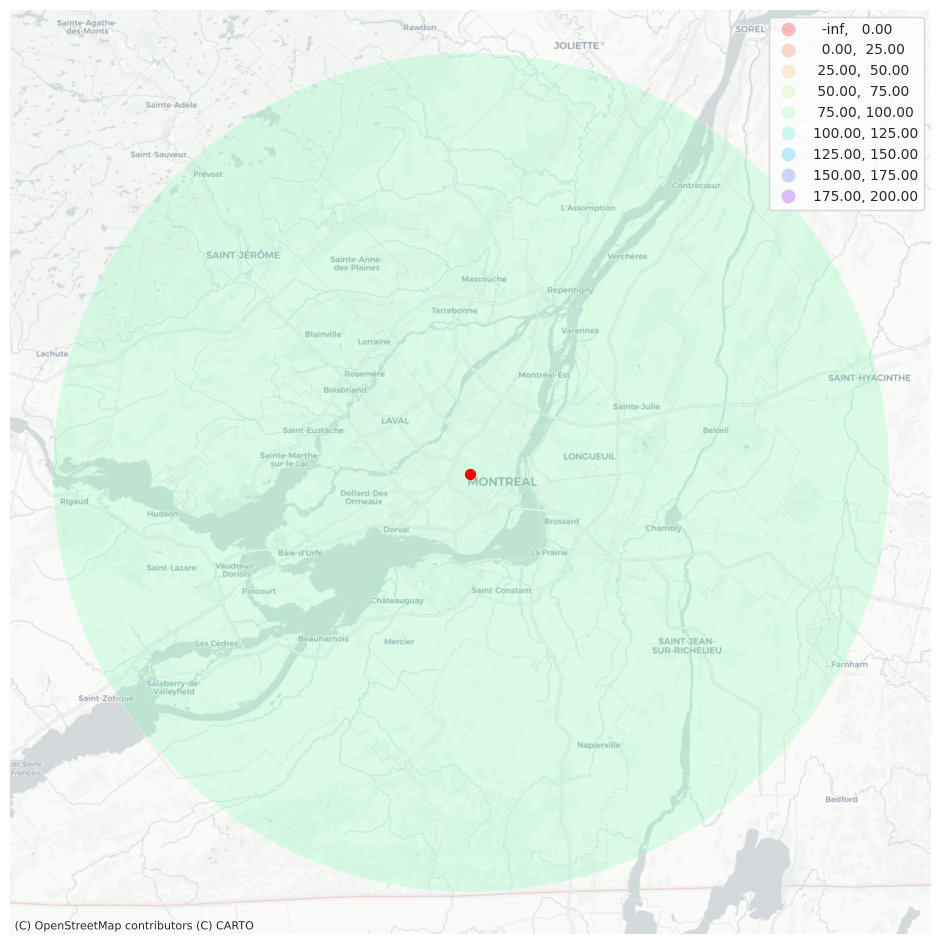

In [146]:
# Show a chloropleth map for the level of autonomy
base = analysis_results_gdf.to_crs(plot_crs).plot(
                column='autonomy', 
                cmap='rainbow_r', 
                scheme='user_defined', 
                classification_kwds={'bins':[0, 25, 50, 75, 100, 125, 150, 175, 200]},
                legend=True,
                figsize=(12, 12), 
                alpha=0.25, 
                zorder=1)

# Add the urban centers
urban_centers.to_crs(plot_crs).plot(
                ax=base, 
                marker='o', 
                color='red', 
                markersize=50,
                zorder=2,)

# Add a map
cx.add_basemap(ax=base,
               zoom=10,
               source=cx.providers.CartoDB.Positron) # différents styles : https://geopandas.org/en/stable/gallery/plotting_basemap_background.html

# Remove the axis         
base.set_axis_off()

# Export the image
plt.savefig(output_folder + "/Results_study.png", dpi=500)